In [1]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import gmean
from tqdm import tqdm_notebook
tqdm_notebook().pandas()
import matplotlib.pyplot as plt
import seaborn as sns

#%% Code so the same scripts can be used as notebooks and as part of a pipeline
try:
    if __IPYTHON__:
        import sys
        sys.path.insert(0,'./bin')
except:
    pass

from pipeline_utils.ic_utils import get_IC, get_observed_variance, get_pb_variance
from pipeline_utils.vrs_utils import get_vrs, get_cvrs

/home/iakovl0000/anaconda3/envs/stochastic/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
dataset = "somatosensory_rpkm_suppl"
prefix = "Pcdh"

In [3]:
data_df = pd.read_csv(dataset+".csv", index_col="gene_id")

In [4]:
thresholds_df = {x: pd.read_csv("{}/intermediate/{}/optimal_thresholds.csv".format(dataset,x), index_col="gene_id") for x in ["vrs", "3max", "geomean"]}

In [5]:
if dataset != "olfactory_dataset":
    thresholds_df["fitted"] = pd.read_csv("{}/mathematica/fitted_distributions_thresholds.csv".format(dataset), index_col="gene_id")

In [6]:
def get_np_func(name):
    if (name == "min"):
        return np.nanmin
    elif (name == "max"):
        return np.nanmax
    elif (name == "median"):
        return np.nanmedian

def get_threshold(genes, take_n=3, cutoff=0.0, bottom_func="min", top_func="max"):
    bottom = [row[row > cutoff].sort_values()[:take_n].mean() for _, row in genes.iterrows()]
    top = [row[row > cutoff].sort_values()[-take_n:].mean() for _, row in genes.iterrows()]
    return gmean([get_np_func(bottom_func)(bottom), get_np_func(top_func)(top)])

def get_max_min_ratios(genes, take_n=3, cutoff=0.0):
    bottom = np.array([row[row > cutoff].sort_values()[:take_n].mean() for _, row in genes.iterrows()])
    top = np.array([row[row > cutoff].sort_values()[-take_n:].mean() for _, row in genes.iterrows()])
    return pd.Series(top / bottom, index=genes.index)

def dichotomise(df, threshold):
    if(isinstance(threshold, pd.Series)):
        for gene_id, row in df.iterrows():
            row = dichotomise(row, threshold.loc[gene_id])
    else:
        df[df < threshold] = 0
        df[df >= threshold] = 1
    return df

In [7]:
def pipeline(kwargs, genes_df, threshold=None):
    if threshold is None:
        threshold = get_threshold(genes_df, **kwargs)
    if(not isinstance(threshold, pd.Series)):
        kwargs["uncorrected_threshold"] = threshold
        threshold = max(0.5,threshold)
        kwargs["threshold"] = threshold
    dichotomised_df = dichotomise(genes_df.copy(), threshold)
    kwargs["obs_var"] = obs_var = get_observed_variance(dichotomised_df)
    kwargs["pb_var"] = pb_var = get_pb_variance(dichotomised_df)
    kwargs["ic"] = ic = get_IC(obs_var, pb_var)
    kwargs["expression_mean"] = expression_mean = dichotomised_df.sum(axis=0).mean()
    return kwargs, dichotomised_df

def heatmap_pipline(kwargs, genes_df):
    output, dichotomised_df = pipeline(kwargs, genes_df)
    plt.figure(figsize=(16,10))
    sns.heatmap(
        dichotomised_df.loc[dichotomised_df.sum(axis=1) > 0],
        linewidths=.5,linecolor="grey"
    )
    display(output)

In [8]:
if(prefix == "Pcdha" or prefix == "Pcdh"):
    genes_df = data_df.loc[data_df.index.str.startswith(prefix)].drop_duplicates().drop("Pcdha4-g")
if(prefix == "clustered_pcdh"):
    genes_df = data_df.loc[data_df.index.str.startswith("Pcdha") | data_df.index.str.startswith("Pcdhb") | data_df.index.str.startswith("Pcdhg")].drop_duplicates().drop("Pcdha4-g")
else:
    genes_df = data_df.loc[data_df.index.str.startswith(prefix)].drop_duplicates()
    
genes_df

,100_FPKM,101_FPKM,102_FPKM,103_FPKM,104_FPKM,105_FPKM,106_FPKM,107_FPKM,108_FPKM,109_FPKM,...,90_FPKM,91_FPKM,92_FPKM,93_FPKM,94_FPKM,95_FPKM,96_FPKM,97_FPKM,98_FPKM,99_FPKM
gene_id,,,,,,,,,,,,,,,,,,,,,
Pcdh1,0.00000,0.564346,0.896061,0.312393,2.62369,0.379052,3.649910,4.538780,5.963640,4.953000,...,0.053389,0.000000,0.061051,0.000000,0.087526,1.432070,0.0000,0.000000,0.000000,0.000000
Pcdh10,10.55660,3.116200,3.704680,7.096600,0.00000,0.600951,0.098575,2.317770,0.000000,0.979147,...,0.012658,0.675185,0.000000,0.000000,0.000000,4.847590,0.0000,0.024397,0.002917,0.000000
Pcdh11x,0.00000,0.000000,0.000000,0.002524,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.059480,0.000000,0.000000,0.003380,0.000000,0.617017,0.0000,0.000000,0.000000,0.000000
Pcdh12,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.010212,0.000000
Pcdh15,0.00000,0.000000,1.163580,0.000000,0.00000,0.000000,0.000000,0.011473,0.000000,0.004241,...,0.116798,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pcdhgb7,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
Pcdhgb8,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000
Pcdhgc3,5.52184,0.217033,0.000000,3.161300,8.33727,0.000000,2.231140,6.024380,0.089167,0.000000,...,0.000000,0.000000,5.606840,13.251800,11.222000,1.645120,10.3578,32.782700,0.168534,0.035882


vrs
VRS:  6.514414206252147


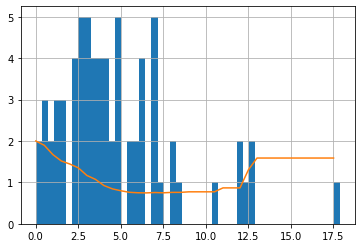

3max
VRS:  2.0042198266666666


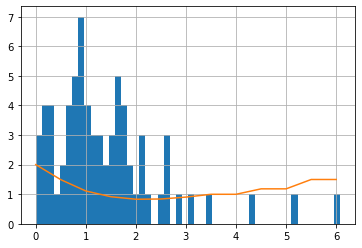

geomean
VRS:  0.5212170504969522


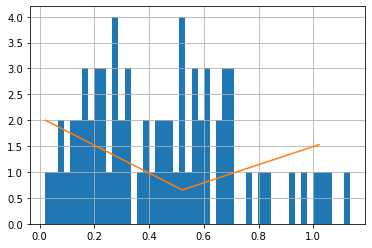

fitted
VRS:  1.003738317352033


/home/iakovl0000/anaconda3/envs/stochastic/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  This is separate from the ipykernel package so we can avoid doing imports until


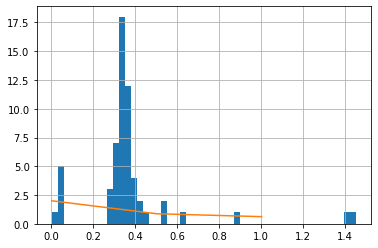

In [9]:
for x in ["vrs", "3max", "geomean", "fitted"] if dataset != "olfactory_dataset" else ["vrs", "3max", "geomean"]:
    print(x)
    selected_thresholds = thresholds_df[x].loc[genes_df.index]
    x = np.arange(np.nanmin(selected_thresholds), np.nanmax(selected_thresholds), 0.5)
    cvrs = [get_cvrs(selected_thresholds[~selected_thresholds.uncorrected_threshold.isna()].uncorrected_threshold, _x) * 2 for _x in x]
    vrs = [get_vrs(selected_thresholds[~selected_thresholds.uncorrected_threshold.isna()].uncorrected_threshold, _x) * 2 for _x in x]

    # np.log(selected_thresholds[~selected_thresholds.uncorrected_threshold.isna()].uncorrected_threshold).hist(bins=50)
    # plt.show()
    (selected_thresholds[~selected_thresholds.uncorrected_threshold.isna()].uncorrected_threshold).hist(bins=50)
    plt.plot(x, vrs, label="VRS")
    print("VRS: ",x[np.argmin(vrs)])
    # plt.plot(x, cvrs, label="CVRS")
    # print("CVRS: ",x[np.nanargmin(cvrs)])
    plt.show()

In [10]:
output = {
    "minmax_00": pipeline({
        "take_n": 3,
        "cutoff": 0,
        "bottom_func": "min",
        "top_func": "max"
    }, genes_df)[0],
    "minmax_05": pipeline({
        "take_n": 3,
        "cutoff": 0.4999,
        "bottom_func": "min",
        "top_func": "max"
    }, genes_df)[0],
    "median_00": pipeline({
        "take_n": 3,
        "cutoff": 0,
        "bottom_func": "median",
        "top_func": "median"
    }, genes_df)[0],
    "median_05": pipeline({
        "take_n": 3,
        "cutoff": 0.4999,
        "bottom_func": "median",
        "top_func": "median"
    }, genes_df)[0],
    "mean_vrs": pipeline(
        {},
        genes_df,
        threshold=thresholds_df["vrs"].loc[genes_df.index].uncorrected_threshold.mean()
    )[0],
    "median_vrs": pipeline(
        {},
        genes_df,
        threshold=thresholds_df["vrs"].loc[genes_df.index].uncorrected_threshold.median()
    )[0],
    "mean_3max": pipeline(
        {},
        genes_df,
        threshold=thresholds_df["3max"].loc[genes_df.index].uncorrected_threshold.mean()
    )[0],
    "median_3max": pipeline(
        {},
        genes_df,
        threshold=thresholds_df["3max"].loc[genes_df.index].uncorrected_threshold.median()
    )[0],
    "mean_geomean": pipeline(
        {},
        genes_df,
        threshold=thresholds_df["geomean"].loc[genes_df.index].uncorrected_threshold.mean()
    )[0],
    "median_geomean": pipeline(
        {},
        genes_df,
        threshold=thresholds_df["geomean"].loc[genes_df.index].uncorrected_threshold.median()
    )[0]
}

if(dataset != "olfactory_dataset"):
    output["mean_fitted"] = pipeline(
        {},
        genes_df,
        threshold=thresholds_df["fitted"].loc[genes_df.index].uncorrected_threshold.mean()
    )[0]
    output["median_fitted"] = pipeline(
        {},
        genes_df,
        threshold=thresholds_df["fitted"].loc[genes_df.index].uncorrected_threshold.median()
    )[0]

uniform_output_df = pd.DataFrame(output).iloc[4:].T

/home/iakovl0000/anaconda3/envs/stochastic/lib/python3.7/site-packages/ipykernel_launcher.py:62: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/home/iakovl0000/anaconda3/envs/stochastic/lib/python3.7/site-packages/ipykernel_launcher.py:67: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


In [11]:
vals = genes_df[genes_df >= 0.5].values.flatten()
vals = sorted(vals[~np.isnan(vals)])

In [12]:
ics = pd.DataFrame([pipeline({}, genes_df, threshold=x)[0] for x in tqdm_notebook(vals)])

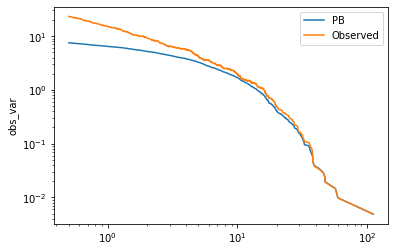

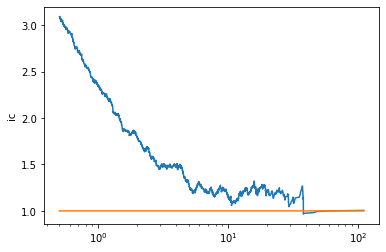

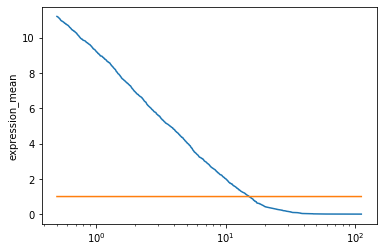

In [19]:
sns.lineplot(vals, ics.pb_var, label="PB")
sns.lineplot(vals, ics.obs_var, label="Observed")
plt.yscale("log")
plt.xscale("log")
plt.show()

# sns.lineplot(vals, ics.obs_var-ics.pb_var, label="Difference")
# sns.lineplot(vals, np.zeros(len(vals)), label="Difference")
# plt.xscale("log")
# plt.show()

sns.lineplot(vals, ics.ic)
sns.lineplot(vals, np.ones(len(vals)))
# plt.yscale("log")
plt.xscale("log")
plt.show()

sns.lineplot(vals, ics.expression_mean)
sns.lineplot(vals, np.ones(len(vals)))
# plt.yscale("log")
plt.xscale("log")
plt.show()



In [18]:
ics

,uncorrected_threshold,threshold,obs_var,pb_var,ic,expression_mean
0,0.500294,0.500294,23.245122,7.520593,3.090863,11.200980
1,0.501847,0.501847,23.222448,7.516965,3.089338,11.196078
2,0.504134,0.504134,23.248986,7.513625,3.094244,11.191176
3,0.506184,0.506184,23.206510,7.511198,3.089589,11.186275
4,0.506625,0.506625,23.124577,7.507425,3.080228,11.181373
...,...,...,...,...,...,...
2280,47.162700,47.162700,0.024027,0.024342,0.987070,0.024510
2281,47.321700,47.321700,0.019318,0.019464,0.992520,0.019608
2282,56.861400,56.861400,0.014561,0.014586,0.998304,0.014706
2283,59.532400,59.532400,0.009756,0.009756,0.999976,0.009804


In [14]:
uniform_df = dichotomise(genes_df.copy(), max(0.5, get_threshold(genes_df)))

In [15]:
isinstance(thresholds_df["vrs"].loc[genes_df.index].threshold, pd.Series)

True

In [16]:
separate = {x: pipeline({}, genes_df.copy(), threshold=thresholds_df[x].threshold)[0] for x in ["vrs", "3max", "geomean"]}
ic_summary = pd.concat([uniform_output_df, pd.DataFrame(separate).T], sort=False)
display(ic_summary)
print(ic_summary.fillna(0).to_latex(float_format="%.2f"))

,uncorrected_threshold,threshold,obs_var,pb_var,ic,expression_mean
minmax_00,0.285416,0.5,23.2451,7.52059,3.09086,11.201
minmax_05,5.57998,5.57998,3.55112,2.93663,1.20925,3.64216
median_00,0.456422,0.5,23.2451,7.52059,3.09086,11.201
median_05,2.79413,2.79413,6.76673,4.51288,1.49943,5.82353
mean_vrs,4.79109,4.79109,4.49078,3.38889,1.32515,4.22549
median_vrs,3.90907,3.90907,5.78142,3.87149,1.49333,4.89216
mean_3max,1.41783,1.41783,12.018,5.90612,2.03485,8.16176
median_3max,1.19752,1.19752,13.5946,6.19464,2.19458,8.73529
mean_geomean,0.451558,0.5,23.2451,7.52059,3.09086,11.201
median_geomean,0.433959,0.5,23.2451,7.52059,3.09086,11.201


\begin{tabular}{lrrrrrr}
\toprule
{} &  uncorrected\_threshold &  threshold &  obs\_var &  pb\_var &   ic &  expression\_mean \\
\midrule
minmax\_00      &                   0.29 &       0.50 &    23.25 &    7.52 & 3.09 &            11.20 \\
minmax\_05      &                   5.58 &       5.58 &     3.55 &    2.94 & 1.21 &             3.64 \\
median\_00      &                   0.46 &       0.50 &    23.25 &    7.52 & 3.09 &            11.20 \\
median\_05      &                   2.79 &       2.79 &     6.77 &    4.51 & 1.50 &             5.82 \\
mean\_vrs       &                   4.79 &       4.79 &     4.49 &    3.39 & 1.33 &             4.23 \\
median\_vrs     &                   3.91 &       3.91 &     5.78 &    3.87 & 1.49 &             4.89 \\
mean\_3max      &                   1.42 &       1.42 &    12.02 &    5.91 & 2.03 &             8.16 \\
median\_3max    &                   1.20 &       1.20 &    13.59 &    6.19 & 2.19 &             8.74 \\
mean\_geomean   &             

In [17]:
if dataset == "olfactory_dataset":
    threshold_summary = pd.DataFrame([thresholds_df[x].loc[genes_df.index].uncorrected_threshold for x in ["vrs", "3max", "geomean"]], index=["vrs", "3max", "geomean"]).T.describe()
else:
    threshold_summary = pd.DataFrame([thresholds_df[x].loc[genes_df.index].uncorrected_threshold for x in ["vrs", "3max", "geomean", "fitted"]], index=["vrs", "3max", "geomean", "fitted"]).T.describe()
display(threshold_summary)
print(threshold_summary.fillna(0).to_latex(float_format="%.2f"))

/home/iakovl0000/anaconda3/envs/stochastic/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


,vrs,3max,geomean,fitted
count,70.000000,71.000000,71.000000,59.000000
mean,4.791085,1.417830,0.451558,0.373924
std,3.502309,1.120645,0.270070,0.242159
min,0.016947,0.004220,0.021217,0.003738
25%,2.588646,0.733488,0.233529,0.321925
50%,3.909067,1.197519,0.433959,0.340030
75%,6.325559,1.811472,0.615452,0.368398
max,17.902150,6.083040,1.133533,1.454081


\begin{tabular}{lrrrr}
\toprule
{} &   vrs &  3max &  geomean &  fitted \\
\midrule
count & 70.00 & 71.00 &    71.00 &   59.00 \\
mean  &  4.79 &  1.42 &     0.45 &    0.37 \\
std   &  3.50 &  1.12 &     0.27 &    0.24 \\
min   &  0.02 &  0.00 &     0.02 &    0.00 \\
25\%   &  2.59 &  0.73 &     0.23 &    0.32 \\
50\%   &  3.91 &  1.20 &     0.43 &    0.34 \\
75\%   &  6.33 &  1.81 &     0.62 &    0.37 \\
max   & 17.90 &  6.08 &     1.13 &    1.45 \\
\bottomrule
\end{tabular}

